In [577]:
# %pip install tensorflow
# %pip install keras

# %pip install --upgrade keras
# %pip install --upgrade keras-cv
# %pip install --upgrade keras-hub
# %pip install --upgrade keras
# %pip install --upgrade typing_extensions



# Config for the Neural Network
KFOLD                           = 5     # N-Fold Cross Validation | False can deactivate KFold -> single training
EPOCHS                          = 10    # rounds of training
LEARNING_RATE                   = 0.001 # 0.001 is the default value for Adam Optimizer
BATCH_SIZE                      = 60    # after n samples, weights will be updated
SAVE_MODELS_AND_WEIGHTS         = False # Saves all Models&Weights in a folder from each KFold

# Config for 1 or 2 Hidden Layers in the Neural Network | True = ON, False = OFF
Layer_ONE                       = True
Layer_TWO                       = True

# Neurons
HiddenLayer_ONE_Neurons         = 32
HiddenLayer_TWO_Neurons         = 16
Output_Neurons                  = 10   # Assuming MNIST digits: 10 output classes

# 0 = sigmoid, 1 = tanh, 2 = relu, 3 = leaky relu, 4 = softmax 
ChooseActivationFunction_ONE    = 1 
ChooseActivationFunction_TWO    = 1 
ChooseActivationFunction_OUTPUT = 4 

# Imports 
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time  

In [578]:
if KFOLD:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # Verify that the datasets have the expected shapes.
    assert x_train.shape == (60000, 28, 28)  # Training set 60,000 images.
    assert y_train.shape == (60000,)         # Training labels
else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    assert x_train.shape == (60000, 28, 28) 
    assert x_test.shape  == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape  == (10000,)


In [579]:
# For defining the activation functions in the model
# Prepared for Max 2 Hidden Layers and 1 Output Layer

def Layer_ONE_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def Layer_TWO_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def OUTPUT_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"


#------------------------------------------------------------------------------
# Model CONFIGURATION
#------------------------------------------------------------------------------
def create_model():
  if Layer_ONE:
    activation_one = Layer_ONE_ACTIVATION(ChooseActivationFunction_ONE)

  if Layer_TWO:
    activation_two = Layer_TWO_ACTIVATION(ChooseActivationFunction_TWO)

  if Output_Neurons: 
    activation_output = OUTPUT_ACTIVATION(ChooseActivationFunction_OUTPUT)


  # Build the model using the chosen activations
  layers = [
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Flatten()
  ]

  if Layer_ONE:
    layers.append(tf.keras.layers.Dense(HiddenLayer_ONE_Neurons, activation=activation_one))

  if Layer_TWO:
    layers.append(tf.keras.layers.Dense(HiddenLayer_TWO_Neurons, activation=activation_two))

  layers.append(tf.keras.layers.Dense(Output_Neurons, activation=activation_output))

  model = tf.keras.Sequential(layers)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

  return model
# end create_model()

# K-Fold loops create a model for each fold and train it.
if KFOLD:
  print("KFOLD")
  pass

# Single Version needs only one model and callback
if not KFOLD:
  print("NOT KFOLD")
  model = create_model()
  
  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',        # Metric to be monitored.
      patience=2,                # Number of epochs to wait for improvement before stopping.
      restore_best_weights=True  # Restore model weights from the epoch with the best monitored metric.
  )

  

KFOLD


In [580]:


if KFOLD:
  kfold = KFold(n_splits=KFOLD, shuffle=True)
  fold_accuracies = []      # store accuracies for each fold
  histories = []            # list of History objects | for Printing
  fold_training_times = []  # store training time for each fold
  i = 0                     # counter for saving models and weights

  for train_idx, val_idx in kfold.split(x_train):
    model = create_model()                              # new model for this run
    early_stop = tf.keras.callbacks.EarlyStopping()     # new early stopping for this run

    x_train_fold, x_val_fold = x_train[train_idx]/255.0, x_train[val_idx]/255.0   # normalize the data
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]               # get the labels

    start_time = time.time()
    history = model.fit(
      x_train_fold, y_train_fold,                     # training data for this fold
      validation_data=(x_val_fold, y_val_fold),       # validation data for this fold
      epochs=EPOCHS,                                  # number of epochs to train
      batch_size=BATCH_SIZE,                          # after how many samples to update the weights
      callbacks=[early_stop]                          # backpropagation with early stopping
    )

    # Measure the time taken for training this fold + save in fold_training_times[]
    end_time = time.time()
    elapsed_time = end_time - start_time
    fold_training_times.append(elapsed_time)
    print(f"Fold training time: {elapsed_time:.2f} seconds")
  
    histories.append(history)                               # Save the history object for later analysis
    loss, accuracy = model.evaluate(x_val_fold, y_val_fold) # Evaluate model on validation data
    fold_accuracies.append(accuracy)                        # Save the accuracy for this fold

    if SAVE_MODELS_AND_WEIGHTS:                             # was for testing with single models after training
      os.makedirs("Models", exist_ok=True)
      model.save(f"Models/saved_model_{i}.keras")
      model.save_weights(f"Models/saved_weights_{i}.weights.h5")
      i += 1
  
else:
  start_time = time.time() 
  history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Training time: {elapsed_time:.2f} seconds")
  loss, accuracy = model.evaluate(x_test, y_test)

  if SAVE_MODELS_AND_WEIGHTS:                             # was for testing with single models after training
    os.makedirs("Models", exist_ok=True)
    model.save(f"Models/saved_model_.keras")
    model.save_weights(f"Models/saved_weights_{i}.weights.h5")


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7841 - loss: 0.8500 - val_accuracy: 0.9252 - val_loss: 0.2683
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9341 - loss: 0.2372 - val_accuracy: 0.9417 - val_loss: 0.2006
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9498 - loss: 0.1784 - val_accuracy: 0.9469 - val_loss: 0.1730
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9605 - loss: 0.1419 - val_accuracy: 0.9520 - val_loss: 0.1569
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9678 - loss: 0.1133 - val_accuracy: 0.9544 - val_loss: 0.1460
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9704 - loss: 0.1047 - val_accuracy: 0.9528 - val_loss: 0.1538
Fold training time: 12.62 seconds
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9500 - loss: 0.1651
Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7802 - loss: 0.8510 - val_accuracy: 0.9202 - val_loss: 0.

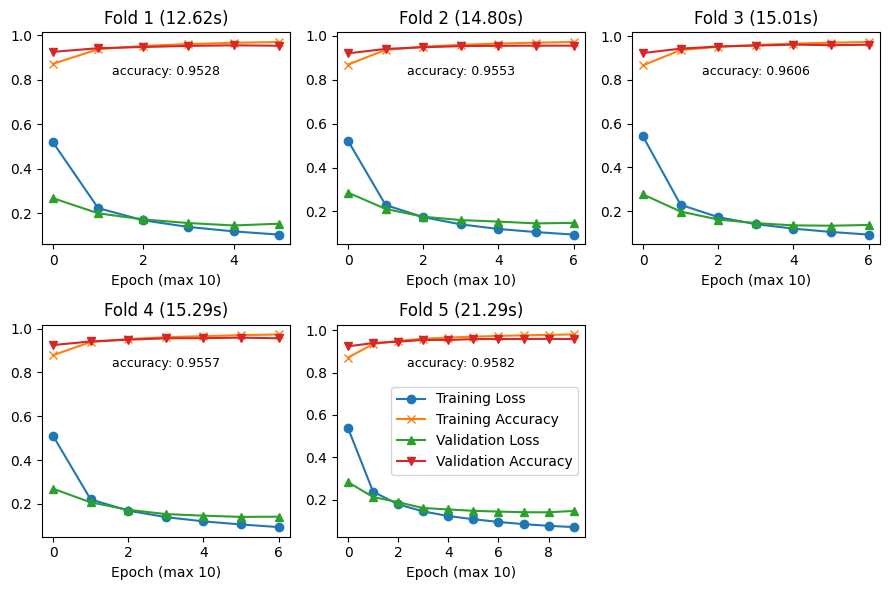

In [613]:
if KFOLD:
    n_folds = len(histories)
    if n_folds >= 5:
        cols = (n_folds + 1) // 2  
        rows = 2
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1, n_folds, figsize=(n_folds * 2, 2))
        if n_folds == 1:
            axs = [axs]

    for i, hist in enumerate(histories):
        ax = axs[i]
        ax.plot(hist.history['loss'], marker='o', label='Training Loss')
        ax.plot(hist.history['accuracy'], marker='x', label='Training Accuracy')
        ax.plot(hist.history.get("val_loss", [None]*len(hist.history['loss'])), marker='^', label='Validation Loss')
        ax.plot(hist.history.get("val_accuracy", [None]*len(hist.history['accuracy'])), marker='v', label='Validation Accuracy')
        ax.set_xlabel(f'Epoch (max {EPOCHS})')
        ax.set_title(f'Fold {i+1} ({fold_training_times[i]:.2f}s)')
        ax.text(0.5, 0.8, f"accuracy: {fold_accuracies[i]:.4f}", transform=ax.transAxes, ha='center', fontsize=9)

    if len(axs) > n_folds:
        for ax in axs[n_folds:]:
            fig.delaxes(ax)
            
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    plt.figure(figsize=(3,2))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.plot(history.history['accuracy'], marker='x', label='Training Accuracy')
    plt.plot(history.history.get("val_loss", [None]*len(history.history['loss'])), marker='^', label='Validation Loss')
    plt.plot(history.history.get("val_accuracy", [None]*len(history.history['accuracy'])), marker='v', label='Validation Accuracy')
    plt.xlabel(f'Epoch (max {EPOCHS})')
    plt.title(f'Training (time: {elapsed_time:.2f}s)')
    plt.legend()
    plt.show()


In [616]:
for i, hist in enumerate(histories, 1):
    epochs = range(1, len(hist.history['loss']) + 1)
    
    # Header mit Validation Accuracy
    header = f"{'Epoch':<5} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}"
    print(f"Results for Fold {i}:")
    print(header)
    
    for epoch, loss, acc, v_loss, v_acc in zip(epochs,
                                               hist.history['loss'],
                                               hist.history['accuracy'],
                                               hist.history.get("val_loss", [None]*len(epochs)),
                                               hist.history.get("val_accuracy", [None]*len(epochs))):
        v_loss_str = "None" if v_loss is None else f"{v_loss:.4f}"
        v_acc_str = "None" if v_acc is None else f"{v_acc:.4f}"
        print(f"{epoch:<5} {loss:<12.4f} {acc:<12.4f} {v_loss_str:<12} {v_acc_str:<12}")
    print()

Results for Fold 1:
Epoch Train Loss   Train Acc    Val Loss     Val Acc     
1     0.5187       0.8716       0.2683       0.9252      
2     0.2239       0.9370       0.2006       0.9417      
3     0.1691       0.9517       0.1730       0.9469      
4     0.1392       0.9603       0.1569       0.9520      
5     0.1195       0.9659       0.1460       0.9544      
6     0.1050       0.9696       0.1538       0.9528      

Results for Fold 2:
Epoch Train Loss   Train Acc    Val Loss     Val Acc     
1     0.5222       0.8693       0.2857       0.9202      
2     0.2295       0.9359       0.2119       0.9404      
3     0.1744       0.9505       0.1761       0.9480      
4     0.1412       0.9591       0.1608       0.9532      
5     0.1204       0.9649       0.1540       0.9547      
6     0.1062       0.9690       0.1457       0.9553      
7     0.0948       0.9721       0.1482       0.9553      

Results for Fold 3:
Epoch Train Loss   Train Acc    Val Loss     Val Acc     
1     0.54

In [617]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display



urls = [
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true"
]

# Takes last model from KFold or the model trained on the full dataset
for idx, url in enumerate(urls):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            print(f"Image {idx+1} loaded from: {url}")
            display(img)
            
            # Convert to grayscale and resize to 28x28
            img_proc = img.convert("L").resize((28, 28))
            
            # Prepare the image for the model: normalize and add dimensions
            img_arr = 1.0 - np.array(img_proc) / 255.0
            img_arr = img_arr.reshape(1, 28, 28, 1)
            
            # Get prediction from the model
            probs = model.predict(img_arr)
            pred_class = np.argmax(probs)
            
            print(f"Predicted class: {pred_class}")
            print(f"Probabilities: {probs}")
        else:
            print(f"Failed to load image {idx+1} from: {url} with status code {response.status_code}")
    except Exception as e:
        print(f"Error processing image {idx+1} from {url}: {e}")


Image 1 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 3
Probabilities: [[2.42316921e-04 2.12127605e-04 1.10574216e-01 8.73379111e-01
  3.33642750e-03 2.56683864e-03 9.44961421e-03 6.20632127e-05
  7.49002356e-05 1.02362043e-04]]
Image 2 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 7
Probabilities: [[4.1360210e-05 7.8232542e-02 3.8031081e-03 4.7418177e-03 4.5719865e-04
  2.4057559e-03 8.5635227e-05 6.5440023e-01 9.1026485e-02 1.6480589e-01]]
Image 3 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: 3
Probabilities: [[1.0742244e-03 9.6569220e-03 2.3318924e-02 9.3544912e-01 4.0093432e-03
  7.9384996e-03 9.5757376e-03 2.5280160e-04 3.8149872e-05 8.6862156e-03]]
Image 4 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: 6
Probabilities: [[1.0900743e-02 7.7166296e-05 1.3176253e-02 1.9878168e-03 1.3427919e-05
  6.7984976e-02 8.0694485e-01 1.7086098e-06 9.7553045e-02 1.3599548e-03]]
